In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import glob
import time
import cv2

from sklearn.utils import shuffle


%matplotlib inline

In [2]:
from feature import *

_cars, _notcars = list_files(data_dir='./data')

print("Original - Car image count: {}, non-car image count: {}".format(len(_cars), len(_notcars)))

Original - Car image count: 8792, non-car image count: 8968


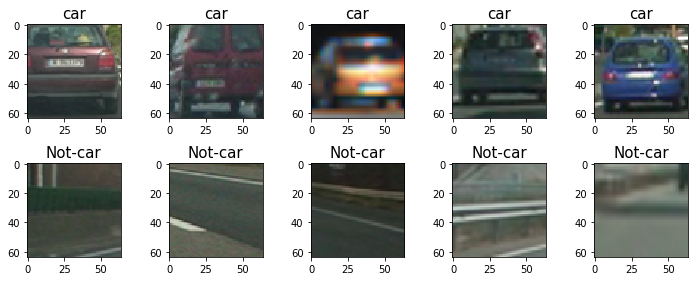

In [3]:
def show_sample(cars, notcars):
    r, c = (2, 5)
    
    f, ax = plt.subplots(r, c, figsize=(10, 4))
    f.tight_layout()
    
    ax = ax.ravel()

    # Make it reproducible
    np.random.seed(1)
    
    for i in range(0, c):
        idx = np.random.randint(0, 2000)

        ax[i].imshow(mpimg.imread(cars[idx]))
        ax[i].set_title("car", fontsize=15)

        ax[c + i].imshow(mpimg.imread(notcars[idx]))
        ax[c + i].set_title('Not-car', fontsize=15)
    
    plt.savefig('./output_images/car_not_car.png')
    plt.show()
    
show_sample(_cars, _notcars)

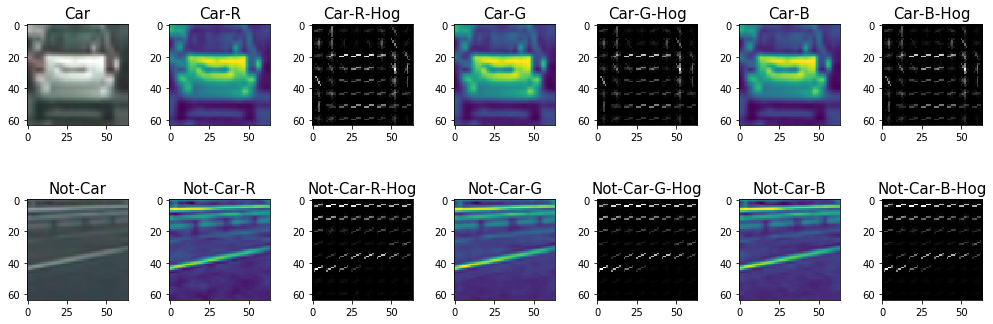

In [62]:
from feature import *
        
params = Params()
        
def show_hog_feature_sample(color_space):    
    car_image = mpimg.imread(_cars[1210])
    notcar_image = mpimg.imread(_notcars[1210])
    
    r, c = (2, 7)

    f, ax = plt.subplots(r, c, figsize=(14, 5))
    f.tight_layout()

    ax = ax.ravel()
    
    for i, img, title in zip(range(0, 2), [car_image, notcar_image], ['Car', 'Not-Car']):
        ax[i * c].imshow(img)
        ax[i * c].set_title(title, fontsize=15)
        
        img = convert_color_space(img, ''.join(color_space))
        
        for channel in range(0, 3):
            channel_image = img[:,:,channel]
            
            ax[i*c + channel*2 + 1].imshow(channel_image)
            ax[i*c + channel*2 + 1].set_title("{}-{}".format(title, color_space[channel]), fontsize=15)
            
            _, hog_image = get_hog_features(channel_image, orient=params.orient, 
                                         pix_per_cell=params.pix_per_cell,
                                         cell_per_block=params.cell_per_block,
                                         vis=True, feature_vec=True)
            ax[i*c + channel*2 + 2].imshow(hog_image, cmap='gray')
            ax[i*c + channel*2 + 2].set_title("{}-{}-Hog".format(title, color_space[channel]), fontsize=15)

show_hog_feature_sample(color_space=['R', 'G', 'B'])

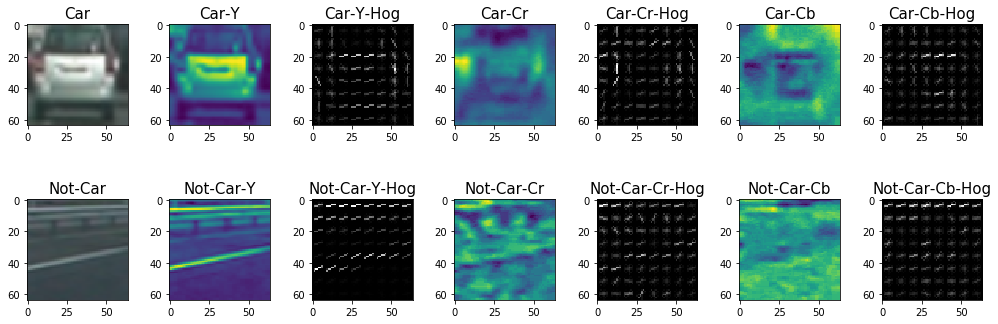

In [60]:
show_hog_feature_sample(color_space=['Y', 'Cr', 'Cb'])

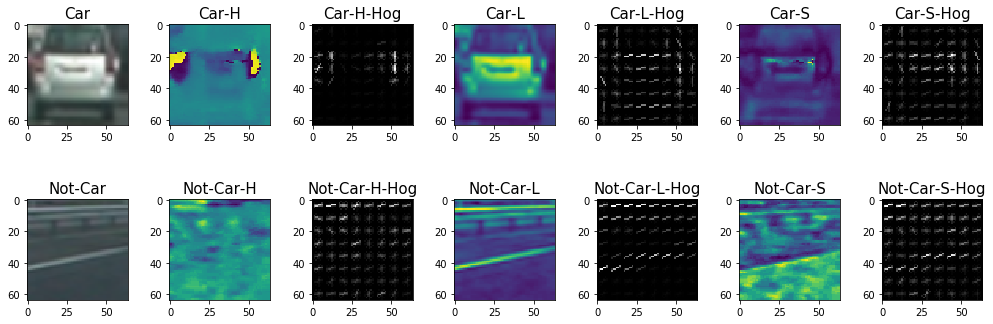

In [61]:
show_hog_feature_sample(color_space=['H', 'L', 'S'])

In [24]:
import matplotlib.image as mpimg
import numpy as np
import cv2

from skimage.feature import hog

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [25]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color_space(img, color_space)
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)

    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)

    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows   

In [26]:
cars = shuffle(_cars)
notcars = shuffle(_notcars)

# Take only part of the data
percent = 0.7

# set the sample size
sample_size = min(len(cars), len(notcars))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

print("Sample - car image count: {}, non-car image count: {}".format(len(cars), len(notcars)))

Sample - car image count: 8792, non-car image count: 8792


In [38]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' #'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
22.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9846


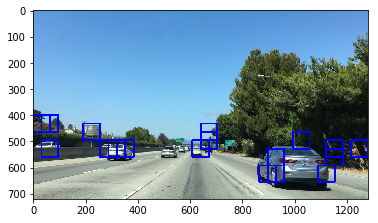

In [39]:
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test_images/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

2.42 Seconds to process test image


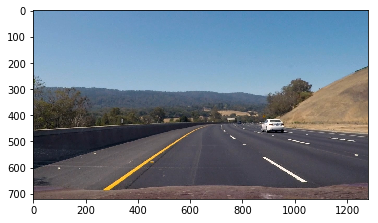

In [40]:
t=time.time() # Start time

image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                xy_window=(96, 96), xy_overlap=(0.7, 0.7))
hot_windows = (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat))                       
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
print(round(time.time()-t, 2), 'Seconds to process test image')

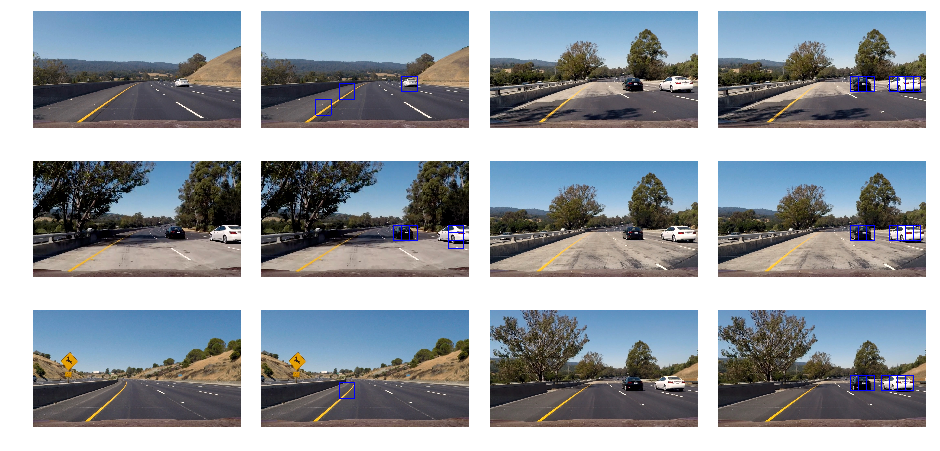

In [41]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)
    draw_image = np.copy(image)
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    hot_windows = (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    axs[i * 2].imshow(image)
    axs[i * 2].axis('off')
    
    axs[i * 2 + 1].imshow(window_img)
    axs[i * 2 + 1].axis('off')

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    img_tosearch = img[ystart:ystop,500:,:]
        
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = img_tosearch 
       
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox_left_top = (500 + xbox_left, ytop_draw+ystart)
                bbox_right_bottom = (500 + xbox_left+win_draw,ytop_draw+win_draw+ystart)
                
                bbox_list.append((bbox_left_top, bbox_right_bottom))
    return bbox_list

In [32]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    heatmap = np.clip(heatmap, 0, 255)

    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image

        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

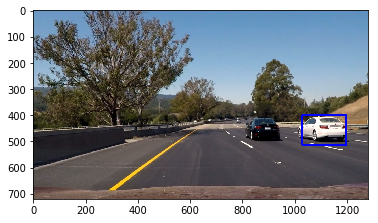

In [33]:
def detect_cars(image):
    new_img = np.copy(image)
    bbox_list = []
    
    multi_window_setting = [
        (400, 1.0),
        (408, 1.0),
        (400, 1.5),
        (420, 1.5),
        (400, 2.0),
        (432, 2.0)
    ]
    
    for ystart, scale in multi_window_setting:
        ystop = ystart + int(64 * scale)
        
        bbox_list.extend(find_cars(image, ystart, ystop, scale, color_space, hog_channel,svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    
#     from skimage.filters import gaussian
#     heat = gaussian(heat, 3)
    
    heat = apply_threshold(heat, len(multi_window_setting)//2+1)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(new_img, labels)
    
    return new_img
    
img = detect_cars(image)
plt.imshow(img)

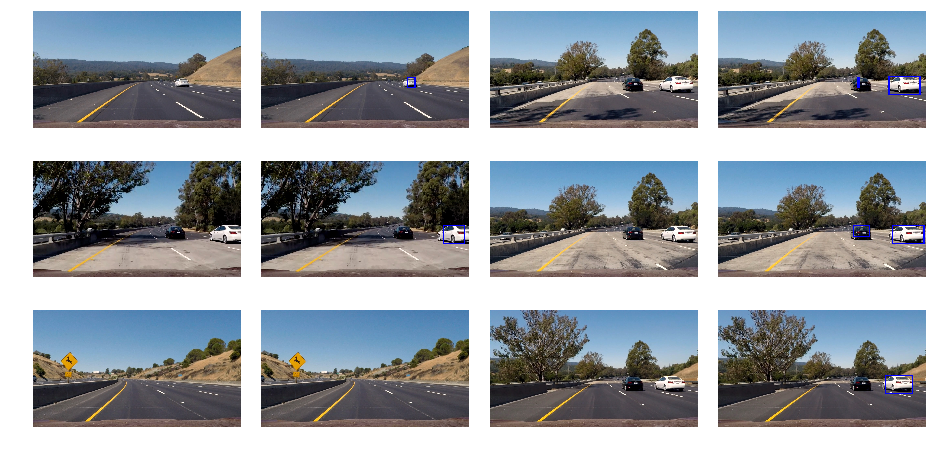

In [34]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)

    axs[i * 2].imshow(image)
    axs[i * 2].axis('off')
    
    axs[i * 2 + 1].imshow(detect_cars(image))
    axs[i * 2 + 1].axis('off')

In [35]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 34 s, sys: 268 ms, total: 34.3 s
Wall time: 10 s


In [37]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(0,10)
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [05:55<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 19min 30s, sys: 13.1 s, total: 19min 44s
Wall time: 5min 56s


## 